# Soft Actor Critic

In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import jax

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib import cm

# import local libraries
from src.systems.linear import StochasticDoubleIntegrator
from src.RL.PolicyGradient.SoftActorCritic_v2.main import SoftActorCritic
from src.RL.PolicyGradient.SoftActorCritic_v2.PolicyFunction import SoftPolicyFunction
from src.RL.PolicyGradient.SoftActorCritic_v2.QFunction import SoftQFunction

from src.utilities.ReplayBuffer import ReplayBuffer
from src.utilities.Tracker import Tracker

## Value Iteration

In [2]:
def cost_to_normalized_reward(x):
    x = x/4.1
    return 0 - min(x, 1)*1

def generate_data(system, N, key):
    it = 0
    buffer = np.zeros((N**3, 6))
    x_space = jnp.linspace(-5, 5, N)
    v_space = jnp.linspace(-5, 5, N)
    u_space = jnp.linspace(-2, 2, N)
    for x in x_space:
        for v in v_space:
            for u in u_space:
                state = jnp.array([x, v])
                cost = system.cost(state, u)
                rew = cost_to_normalized_reward(cost)
                key, _ = jrandom.split(key)
                x1, v1 = system.get_state_update(key, state, u)
                buffer[it] = np.array([x, v, u, rew, x1, v1])
                it += 1
    return buffer

key = jrandom.PRNGKey(0)
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)
buffer = generate_data(SDI, 10, key)

### Training (VI)

In [14]:
# Training loop
seed = 1

batch_size = 100
n_iter = 400
lr_q = 1e-1
lr_pi = 1e0
key = jrandom.PRNGKey(1)

size = len(buffer)

memory = {'param':np.zeros((n_iter, 2))}

SQF = SoftQFunction(3, key, eta=lr_q)
PI = SoftPolicyFunction(2, key, eta=lr_pi, alpha=.2)

for it in range(n_iter):
    keys = jrandom.split(key, 4)
    key = keys[0]
    indexes = jrandom.randint(keys[1], shape=(batch_size,), minval=0, maxval=size)
    
    state = buffer[indexes,:2]
    full_state = buffer[indexes,:3]
    reward = buffer[indexes,3:4]
    next_state = buffer[indexes, -2:]

    loss_q = SQF.update(full_state, reward, next_state, PI, keys[2])
    loss_pi = PI.update(state, SQF.predict, keys[3])
    print(f'loss_q={loss_q:.3f} \t loss_pi={loss_pi:.3f}')

    # Tracking
    memory['param'][it] = PI.model.mu_layer.weight[0]

loss_q=0.028 	 loss_pi=-0.110
loss_q=0.033 	 loss_pi=-0.098
loss_q=0.028 	 loss_pi=0.005
loss_q=0.030 	 loss_pi=0.064
loss_q=0.031 	 loss_pi=0.147
loss_q=0.028 	 loss_pi=0.202
loss_q=0.031 	 loss_pi=0.216
loss_q=0.026 	 loss_pi=0.240
loss_q=0.032 	 loss_pi=0.300
loss_q=0.027 	 loss_pi=0.408
loss_q=0.033 	 loss_pi=0.407
loss_q=0.024 	 loss_pi=0.392
loss_q=0.032 	 loss_pi=0.411
loss_q=0.029 	 loss_pi=0.489
loss_q=0.020 	 loss_pi=0.433
loss_q=0.025 	 loss_pi=0.581
loss_q=0.028 	 loss_pi=0.608
loss_q=0.028 	 loss_pi=0.569
loss_q=0.025 	 loss_pi=0.585
loss_q=0.030 	 loss_pi=0.730
loss_q=0.029 	 loss_pi=0.727
loss_q=0.022 	 loss_pi=0.745
loss_q=0.028 	 loss_pi=0.772
loss_q=0.026 	 loss_pi=0.802
loss_q=0.021 	 loss_pi=0.775
loss_q=0.024 	 loss_pi=0.732
loss_q=0.027 	 loss_pi=0.778
loss_q=0.027 	 loss_pi=0.790
loss_q=0.023 	 loss_pi=0.848
loss_q=0.020 	 loss_pi=0.818
loss_q=0.024 	 loss_pi=0.941
loss_q=0.023 	 loss_pi=0.862
loss_q=0.020 	 loss_pi=0.995
loss_q=0.020 	 loss_pi=0.859
loss_q=0.023

### Results

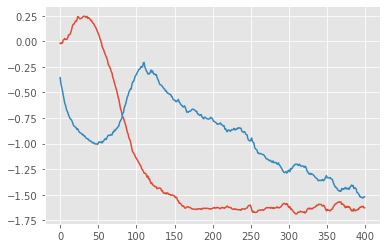

In [15]:
fig, ax = plt.subplots()
ax.plot(memory['param'][:,0])
ax.plot(memory['param'][:,1])
plt.show()

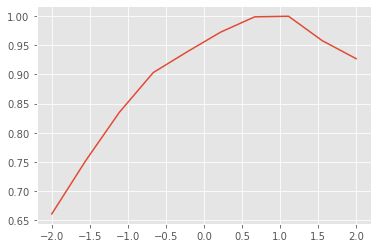

In [16]:

state = -jnp.array([1,1])
u_space = jnp.linspace(-2, 2, 10)
P = np.zeros(10)
for idx, control in enumerate(u_space):
    P[idx] = SQF.predict(state, control)

fig, ax = plt.subplots()
ax.plot(u_space, P)

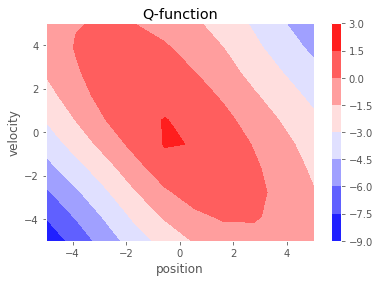

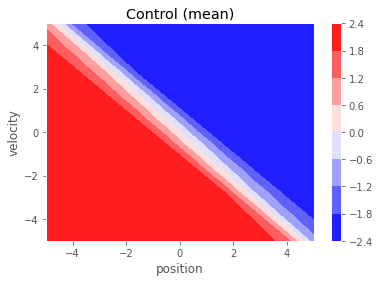

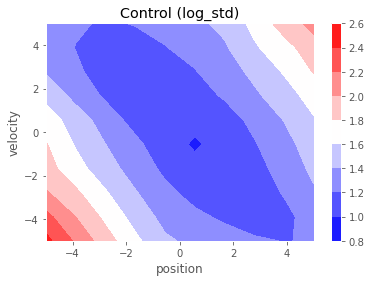

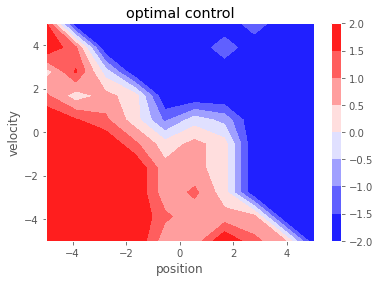

In [17]:
# Plotting
n = 10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
u_space = np.linspace(-2, 2, n)
xv, yv = np.meshgrid(x,y)
zq = np.zeros((n, n))
zu = np.zeros((n, n))
zstd = np.zeros((n, n))
Q = np.zeros((n, n, n))

for i in range(n):
    for j in range(n):
        state = jnp.array([xv[i,j], yv[i,j]])
        for k in range(n):
            u = u_space[k]
            Q[i, j, k] = SQF.predict(state, u)
        q_val = SQF.predict(state, 0)
        u_val, u_log_std = PI.model.predict(state, squash=True)
        zstd[i,j] = u_log_std
        zu[i,j] = u_val
        zq[i,j] = q_val

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (mean)')
plt.show()

plt.contourf(xv, yv, zstd, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (log_std)')
plt.show()

Q_idx = np.argmax(Q, axis=2)
Qu = np.zeros_like(Q_idx, dtype=np.float32)
for i, row in enumerate(Q_idx):
    for j, item in enumerate(row):
        Qu[i,j] = u_space[item]

plt.contourf(xv, yv, Qu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('optimal control')
plt.show()

### Run trial

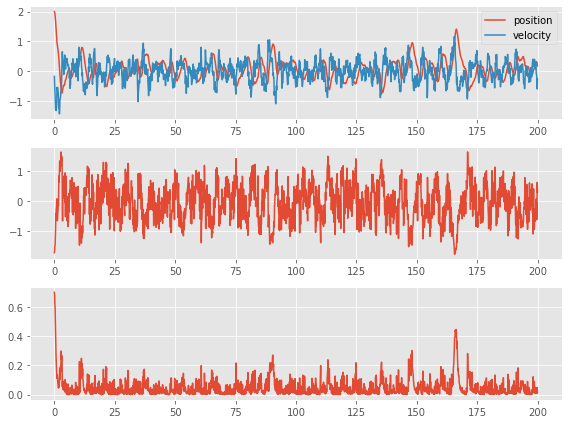

In [7]:
seed = 0
T = 200
n_obs = 2

# Initialize system
x0 = np.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=10)

key = jrandom.PRNGKey(seed)
key0, key1, key = jrandom.split(key, 3)

time_horizon = jnp.arange(0, T, SDI.dt)
n_iter = len(time_horizon)

X = np.zeros((n_iter, n_obs))
U = np.zeros(n_iter)
C = np.zeros(n_iter)

for it, t in enumerate(time_horizon):
    s0_estimate = SDI.observe(key0)
    control, _ = PI.get_control(s0_estimate, key1)
    state, cost, done = SDI.update(key1, control, info=True)

    # save state
    X[it] = state
    U[it] = control
    C[it] = cost

    # step
    key0, key1, key = jrandom.split(key, 3)
    
    if done:
        X = X[:it]
        U = U[:it]
        C = C[:it]
        time_horizon = time_horizon[:it]
        break

fig, ax = plt.subplots(3, figsize=(8,6))
ax[0].plot(time_horizon, X[:, 0], label='position')
ax[0].plot(time_horizon, X[:, -1], label='velocity')
ax[0].legend()
ax[1].plot(time_horizon, U)
ax[2].plot(time_horizon, C)
plt.tight_layout()

## On-Policy Learning

Not yet working

In [4]:
seed = 0
T = 1
batch_size = 100

key = jrandom.PRNGKey(seed)
buffer_size = 1000
n_obs, n_ctrl = 2, 1

# Init environment
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0, boundary=5)
SAC = SoftActorCritic(2, 1, key)

time_horizon = jnp.arange(0, T, SDI.dt)
keys = jrandom.split(key, 6)
s0_estimate = SDI.observe(key)
for t in time_horizon:
    control, _ = SAC.get_control(s0_estimate, keys[0])
    _, cost, done = SDI.update(keys[1], control, info=True)
    s1_estimate = SDI.observe(keys[2])

    state_transition = (s0_estimate, control, cost, s1_estimate)
    SAC.update(state_transition, keys[3])

    # step
    s0_estimate = s1_estimate
    keys = jrandom.split(keys[0], 7)

    if done:
        x0 = jrandom.normal(key, (2,))*2
        SDI.reset(x0)


In [6]:
def run_SAC(system, SAC, T, seed=0):
    key = jrandom.PRNGKey(seed)

    time_horizon = jnp.arange(0, T, SDI.dt)
    keys = jrandom.split(key, 6)

    s0_estimate = SDI.observe(key)
    for _ in time_horizon:
        control, _ = SAC.get_control(s0_estimate, keys[0])
        _, cost, done = system.update(keys[1], control, info=True)
        s1_estimate = SDI.observe(keys[2])

        state_transition = (s0_estimate, control, cost, s1_estimate)
        SAC.update(state_transition, keys[3])

        # step
        s0_estimate = s1_estimate
        keys = jrandom.split(keys[0], 7)

        if done:
            x0 = jrandom.normal(key, (2,))*2
            SDI.reset(x0)
    
    return system, SAC, time_horizon

SDI, SAC, th = run_SAC(SDI, SAC, 10)

2022-12-28 21:00:30.616434: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__normal] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


: 

: 

In [17]:
key = jrandom.PRNGKey(0)
SAC.train(key, batch_size=100, n_epochs=400, show=False)


### Results

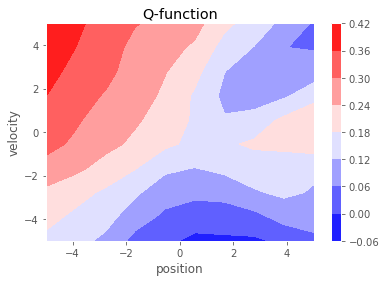

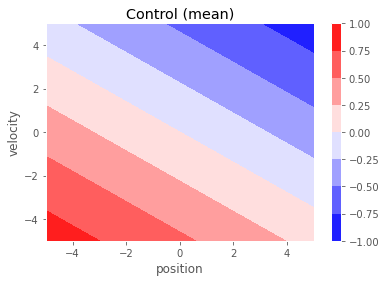

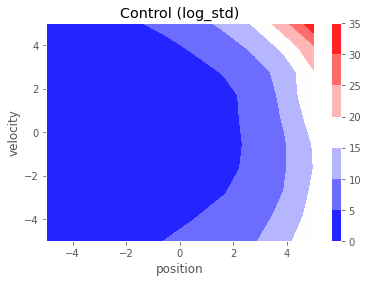

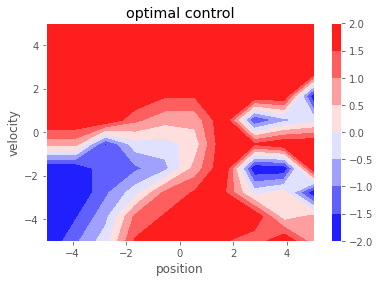

In [4]:
# Plotting
n = 10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
u_space = np.linspace(-2, 2, n)
xv, yv = np.meshgrid(x,y)
zq1 = np.zeros((n, n))
zq2 = np.zeros((n, n))
zq = np.zeros((n, n))
zu = np.zeros((n, n))
zstd = np.zeros((n, n))
Q = np.zeros((n, n, n))

for i in range(n):
    for j in range(n):
        state = jnp.array([xv[i,j], yv[i,j]])
        for k in range(n):
            u = u_space[k]
            q1_value = SAC.SQF_1.predict(state, u)
            q2_value = SAC.SQF_2.predict(state, u)
            Q[i, j, k] = min(q1_value, q2_value)
        q1_val = SAC.SQF_1.predict(state, 0)
        q2_val = SAC.SQF_2.predict(state, 0)
        u_val, u_log_std = SAC.PI.model.predict(state, squash=True)
        zstd[i,j] = u_log_std
        zu[i,j] = u_val
        zq1[i,j] = q1_val
        zq2[i,j] = q2_val
        zq[i,j] = min(q1_val, q2_val)

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (mean)')
plt.show()

plt.contourf(xv, yv, zstd, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control (log_std)')
plt.show()

Q_idx = np.argmax(Q, axis=2)
Qu = np.zeros_like(Q_idx, dtype=np.float32)
for i, row in enumerate(Q_idx):
    for j, item in enumerate(row):
        Qu[i,j] = u_space[item]

plt.contourf(xv, yv, Qu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('optimal control')
plt.show()

## Bin

### Neural Networks

In [7]:
class QNetwork(eqx.Module):
    layer: jnp.ndarray
    
    def __init__(self, in_size, key):
        self.layer = eqx.nn.MLP(in_size=in_size, out_size=1, width_size=32, depth=1, key=key)
    
    def __call__(self, x):
        return self.layer(x)


In [8]:
class PolicyNetwork(eqx.Module):
    """
    Network based on Equinox
    """
    mu_layer: jnp.ndarray
    log_std_layer: jnp.ndarray
    control_lim: jnp.float32
    alpha: jnp.float32

    def __init__(self, in_size, key, control_limit=1):
        """
        Initialize network
        :param dim: network dimensions (n_input, ..., n_output)
        :param key: PRNGKey
        """
        key0, key1, key2, key3 = jrandom.split(key, 4)
        self.control_lim = control_limit
        self.alpha = 0

        self.mu_layer = eqx.nn.Linear(in_size, 1, use_bias=False, key=key0)
        self.log_std_layer = eqx.nn.MLP(in_size=in_size, out_size=1, width_size=32, depth=1, key=key1)

    def __call__(self, x, key, deterministic=False):
        """
        Forward propagation
        :param x: input
        :return: network output
        """
        mu, std = self.predict(x)

        if deterministic:
            control = mu
        else:
            control = mu + std * jrandom.normal(key, (1,))
        
        log_prob = -.5 * ((control - mu) / std)**2 - jnp.log(std) + jnp.log(2*jnp.pi)/2
        
        control = self.control_lim * jnp.tanh(control)
        return control, self.alpha*log_prob
    
    def predict(self, x, squash=False):
        """
        Forward propagation
        :param x: input
        :return: network output
        """
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)
        std = jnp.exp(log_std)
        if squash:
            return jnp.tanh(mu), std
        else:
            return mu, std


### Policy Function

In [ ]:
class PolicyFunction:
    def __init__(self, in_size, key, eta=1e-2):
        self.model = PolicyNetwork(in_size, key)
        self.optimizer = optax.sgd(eta)
        self.opt_state = self.optimizer.init(self.model)
    
    def loss_fn(self, model, D, q_func, keys):
        control, log_prob = jax.vmap(model)(D, keys)
        q_value = jax.vmap(q_func)(D, control)
        return jnp.mean(log_prob - q_value)

    def update(self, D, q_func, key):
        keys = jrandom.split(key, len(D))
        loss, grads = eqx.filter_value_and_grad(self.loss_fn)(self.model, D, q_func, keys)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.model = eqx.apply_updates(self.model, updates)

    def get_control(self, state, key):
        control, log_prob = self.model(state, key)
        return control, log_prob


### Q-Function

In [ ]:
class SoftQFunction:
    def __init__(self, in_size, key, eta=1e-2):
        self.model = SimpleNetwork((in_size, 32, 1), key)
        #self.model = QNetwork(in_size, key)
        self.optimizer = optax.sgd(eta)
        self.opt_state = self.optimizer.init(self.model)
        self.gamma = .9
    
    def update(self, full_state, reward, next_state, policy, key):
        keys = jrandom.split(key, len(full_state))
        control, log_pi = jax.vmap(policy.get_control)(next_state, keys)
        full_state1 = jnp.hstack([next_state, control])
        q1_hat = jax.vmap(self.model)(full_state1)
        q_target = reward + self.gamma * q1_hat

        loss, grads = eqx.filter_value_and_grad(self.loss_fn)(self.model, full_state, q_target)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.model = eqx.apply_updates(self.model, updates)
        return loss
    
    def loss_fn(self, model, full_state, q_target):
        q0_hat = jax.vmap(model)(full_state)
        bellman_residual = jnp.mean((q0_hat - q_target)**2 / 2)
        return bellman_residual
    
    def predict(self, state, control):
        input = jnp.hstack([state, control])
        return self.model(input)
